# Notebook para obtener población y métricas de experimentos con múltiples algoritmos geneticos

## Bibliotecas

In [3]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
#Auxiliares
from tqdm import tqdm
from itertools import compress
from sklearn.preprocessing import MinMaxScaler
#Optimización multiobjetivo 
from pymoo.optimize import minimize
from pymoo.core.repair import Repair
#Algoritmos evolutivos
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
#Operadores 
from pymoo.visualization.scatter import Scatter

#Features pymoo api 
from pymoo.problems import get_problem
from pymoo.termination import get_termination
from pymoo.problems import get_problem
#Indicadores
from pymoo.indicators.hv import HV
#Población (soluciones)
from pymoo.core.population import Population


class Simplex_Repair(Repair):
    def _do(self, problem, X, **kwargs):
        X[X < 1e-5] = 0
        return X / X.sum(axis=1, keepdims=True)

In [4]:
#(n_ejec, n_gen, variable_size, n_var )
def get_best_opt(population, population_var,A = None, A_vars=None,  tol=1e-6):
  pop_size, n_obj = population.shape
  _, n_var = population_var.shape
  #Copia de poblacion
  population = population[:]
  #Guardamos los índices 
  indx = range(pop_size)
  #Archivo fantasma inicial 
  if A is None: 
      A = np.array( [[np.inf]*n_obj])
      A_vars = np.array([[np.inf]*n_obj])
  #best_idx = [None]
  #Iterar sobre los portafolios
  for row in population:
  #for idx, row in zip(indx, population):
    test1 = (A <= row).all(axis=1)
    test2 = np.linalg.norm(A-row, ord=1, axis=1) > tol
    if not ((test1) & (test2)).any(): 
      A = np.vstack([A,row])
      A_vars = np.vstack([A_vars, row])
      #best_idx.append(idx)
      test1 = (row <= A).all(axis=1)
      test2 = np.linalg.norm(row- A, ord=2, axis=1)> tol
      A = A[~((test1) & (test2)) ,:]
      A_vars = A_vars[~((test1) & (test2)) ,:]
      #best_idx = list(compress(best_idx,~((test1) & (test2))))
  return A, A_vars

def get_full_population(res):     
    all_pop = Population()
    for algo in res.history:
        all_pop = Population.merge(all_pop, algo.off)
    X = all_pop.get('X')
    F = all_pop.get('F')
    return X, F 
  
def get_algorithm(name, *args, **kwargs): 
    name = name.lower()
    from pymoo.algorithms.moo.nsga2 import NSGA2
    from pymoo.algorithms.moo.sms import SMSEMOA
    from pymoo.algorithms.moo.age import AGEMOEA
    ALGORITHM = {'nsgaii': NSGA2, 
               'sms-emoa': SMSEMOA, 
               'age-moea': AGEMOEA, 
               }
    if name not in ALGORITHM:
        raise Exception("Algorithm not found.")

    return ALGORITHM[name](*args, **kwargs)

In [5]:
class Generator_Solutions: 
    def __init__(self, n_ejec, n_gen, name_problem, name_algorithm, kwargs_problem, kwargs_algorithm): 
        self.n_ejec = n_ejec 
        self.n_gen  = n_gen 
        self.n_obj = kwargs_problem['n_obj']
        self.n_var = kwargs_problem['n_var']
        self.n_pop_size = kwargs_algorithm['pop_size']
        #PYMOO PROBLEM 
        self.name_problem = name_problem
        try: 
            self.problem = get_problem(name_problem, **kwargs_problem)
        except: 
            self.problem = get_problem(name_problem)
        #PYMOO ALGORITHM  
        self.name_algorithm = name_algorithm 
        self.algorithm = get_algorithm(name_algorithm, **kwargs_algorithm)
        #Terminations Criterio 
        self.termination = get_termination("n_gen", n_gen)
        #(n_ejec, n_gen, n_pop_size, n_var)
        #(n_ejec, n_gen, n_pop_size, n_var)
        self.Mega_X = np.empty((self.n_ejec, self.n_gen, self.n_pop_size, self.n_var))
        self.Mega_F = np.empty((self.n_ejec, self.n_gen, self.n_pop_size, self.n_obj))
    
    def get_extensive_population(self, save=True, name_files=''): 
        for i in range(self.n_ejec): 
            res = minimize(problem = self.problem,
                           algorithm = self.algorithm,
                           termination = self.termination, 
                           save_history=True)
            for j, algo in enumerate(res.history): 
                self.Mega_X[i, j] = algo.off.get('X')
                self.Mega_F[i, j] = algo.off.get('F')
        if save: 
            np.save(name_files+'_X.npy', self.Mega_X)
            np.save(name_files+'_F.npy', self.Mega_F)
                           

In [6]:
class Evaluator_Solutions: 
    def __init__(self, Mega_X: np.ndarray, Mega_F: np.ndarray):
        self.n_ejec, self.n_gen, self.n_pop_size, self.n_var = Mega_X.shape
        _, _ , _ , self.n_obj = Mega_F.shape
        #Falta definir las salidas del HV 
        self.Mega_X = Mega_X[:]
        self.Mega_F = Mega_F[:]
        self.Mega_HV= np.empty((self.n_ejec, self.n_gen))
        self.Mega_HV_Opt = np.empty((self.n_ejec, self.n_gen))
            
    def get_opt_HyperVolume(self, ref_point, tol=1e-4):
        temp_Mega_F = np.reshape(self.Mega_F, newshape=(-1, self.n_obj))
        scaler      = MinMaxScaler()
        scaler.fit(temp_Mega_F) 
        temp_Mega_F = None  #Save RAM memory
        ind = HV(ref_point=ref_point)
        for i in tqdm(range(self.n_ejec)): 
            F_opt = None 
            X_opt = None
            for j in range(self.n_gen): 
                self.Mega_HV[i,j] = ind(scaler.transform(self.Mega_F[i,j]))
                F_opt, X_opt =get_best_opt(self.Mega_F[i,j], self.Mega_X[i,j], F_opt, X_opt, tol)
                #F_opt, A_opt      = get_best_opt(self.Mega_F[i,j]  )
                self.Mega_HV_Opt[i,j] = ind(scaler.transform(F_opt))
        return 
    
    def get_report(self, name_file=''):
        Mega_HV = np.reshape(self.Mega_HV, newshape=(-1,))
        Mega_HV_opt = np.reshape(self.Mega_HV_Opt, newshape=(-1))
        Generacion = list(range(self.n_gen))*self.n_ejec
        Problema   = [self.name_problem]*(self.n_ejec*self.n_gen)
        Algoritmo  = [self.name_algorithm]*(self.n_ejec*self.n_gen)
        Ejecucion = []
        for s in range(self.n_ejec): 
            Ejecucion = Ejecucion+[s+1]*self.n_gen
        result= {'Algoritmo':Algoritmo,
                 'Problema':Problema, 
                 'Ejecucion':Ejecucion, 
                 'Generacion': Generacion, 
                 'HV_gen':Mega_HV, 
                 'HV_opt':Mega_HV_opt}
        result = pd.DataFrame(result)
        result.to_csv(name_file+'.csv', index=False)
        return result   

In [7]:
#Bucle para generar soluciones  
def get_solutions(problems, vars, objs, n_ejec, n_gen, name_algorithm, kwargs_algorithm, name_oprt=''): 
    for i, name_problem in enumerate(problems): 
        print(name_problem)
        sols = Generator_Solutions(n_ejec, n_gen, name_problem, name_algorithm, 
                                   {'n_var': vars[i], 'n_obj': objs[i]}, 
                                   kwargs_algorithm)
        sols.get_extensive_population(save=True, name_files='Solutions/'+name_algorithm+'_'+name_oprt+'_'+name_problem)
    return

In [8]:
#Problems definitions 
dtlz_problems = ['dtlz1', 'dtlz2', 'dtlz3', 'dtlz4', 'dtlz5', 'dtlz6', 'dtlz7']
dtlz_vars = [12]*len(dtlz_problems)
dtlz_obj  = [3]*len(dtlz_problems)
wfg_problems = ['wfg1', 'wfg2', 'wfg3', 'wfg4', 'wfg5', 'wfg6', 'wfg7', 'wfg8', 'wfg9']
wfg_vars     = [24]*len(wfg_problems)
wfg_obj      = [3]*len(wfg_problems)
zdt_problems = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt5', 'zdt6']
zdt_vars     = [30]*3 +[10, 80, 10]
zdt_obj      = [2]*len(zdt_problems)

## Soluciones para NSGA-II simple

In [7]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'nsgaii', 
              {'pop_size':100, 'repair': Simplex_Repair()}, 
              name_oprt='baseline')

dtlz1


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:212: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:222: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
c:\Users\yeudi\AppDa

dtlz2
dtlz3
dtlz4
dtlz5
dtlz6
dtlz7


In [8]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'nsgaii', 
              {'pop_size':100, 'repair': Simplex_Repair()}, 
              name_oprt='baseline')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [9]:
get_solutions(zdt_problems,zdt_vars, zdt_obj, 20, 250, 'nsgaii', 
              {'pop_size':100, 'repair': Simplex_Repair()}, 
              name_oprt='baseline')

zdt1
zdt2
zdt3
zdt4


C:\Users\yeudi\AppData\Local\Temp\ipykernel_9636\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


zdt5
zdt6


## Soluciones para AGE-EMOA simple

In [11]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'age-moea', 
              {'pop_size':100, 'repair': Simplex_Repair()}, 
              name_oprt='baseline')

dtlz1


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:132: RuntimeWarning: divide by zero encountered in divide
  front = front / normalization
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:132: RuntimeWarning: invalid value encountered in divide
  front = front / normalization
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:132: RuntimeWarning: divide by zero encountered in divide
  front = front / normalization
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:132: RuntimeWarning: invalid value encountered in divide
  front = front / normalization


dtlz2
dtlz3
dtlz4


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  p = np.log(n) / np.log(1.0 / np.mean(front[index, :]))
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:170: RuntimeWarning: invalid value encountered in divide
  distances = self.pairwise_distances(front, p) / nn[:, None]
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:202: RuntimeWarning: invalid value encountered in log
  p = np.log(n) / np.log(1.0 / np.mean(front[index, :]))


dtlz5
dtlz6
dtlz7


In [13]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'age-moea', 
              {'pop_size':100, 'repair': Simplex_Repair()}, 
              name_oprt='baseline')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [14]:
get_solutions(zdt_problems,zdt_vars, zdt_obj, 20, 250, 'age-moea', 
              {'pop_size':100, 'repair': Simplex_Repair()}, 
              name_oprt='baseline')

zdt1
zdt2
zdt3
zdt4


C:\Users\yeudi\AppData\Local\Temp\ipykernel_9636\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


zdt5
zdt6


## Nuevos operadores para sampling

In [7]:
from pymoo.core.sampling import Sampling
from pymoo.util.ref_dirs import get_reference_directions
class Sampling_Energy(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        #100 individuos (a lo más 2000)
        #problem.n_var la cantidad de activos. 
        X = get_reference_directions("energy", problem.n_var, n_samples)
        return X 
    
class Sampling_Uniform(Sampling): 
    def _do(self, problem, n_samples, **kwargs): 
        X = self.n_uniform_sampling_simplex(problem.n_var, n_samples)
        return X
    
    def uniform_sampling_simplex(self, n_vars):
        sum = 0
        x = np.zeros(n_vars)
        for i in range(n_vars-1):
            u = np.random.uniform()
            #print(u)
            x[i] = (1-sum)*(1- np.power(u, 1/(n_vars-1-i)))
            sum= sum+x[i]
        x[-1]= 1-sum
        return x

    def n_uniform_sampling_simplex(self, n_vars, n_samples):
        X = np.empty((n_samples, n_vars))
        for i in range(n_samples):
            X[i] = self.uniform_sampling_simplex(n_vars)
        return X

### Soluciones NSGA-II Energy Sampling

In [24]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'sampling': Sampling_Energy(),'repair': Simplex_Repair()}, 
              name_oprt='samp-energy')

dtlz1
dtlz2
dtlz3
dtlz4
dtlz5
dtlz6
dtlz7


In [25]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'sampling': Sampling_Energy(),'repair': Simplex_Repair()}, 
              name_oprt='samp-energy')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [26]:
get_solutions(zdt_problems, zdt_vars, zdt_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'sampling': Sampling_Energy(),'repair': Simplex_Repair()}, 
              name_oprt='samp-energy')

zdt1
zdt2
zdt3
zdt4


C:\Users\yeudi\AppData\Local\Temp\ipykernel_14200\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


zdt5
zdt6


### Soluciones AGE-EMOA Energy Sampling

In [11]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'sampling': Sampling_Energy(),'repair': Simplex_Repair()}, 
              name_oprt='samp-energy')

dtlz1
dtlz2
dtlz3
dtlz4
dtlz5
dtlz6
dtlz7


In [12]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'sampling': Sampling_Energy(),'repair': Simplex_Repair()}, 
              name_oprt='samp-energy')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [19]:
get_solutions(zdt_problems, zdt_vars, zdt_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'sampling': Sampling_Energy(),'repair': Simplex_Repair()}, 
              name_oprt='samp-energy')

zdt1


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:212: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:222: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
c:\Users\yeudi\AppDa

zdt2
zdt3
zdt4


C:\Users\yeudi\AppData\Local\Temp\ipykernel_14200\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


zdt5
zdt6


## Soluciones NSGA-II Uniform Random Sampling 

In [27]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'sampling': Sampling_Uniform(),'repair': Simplex_Repair()}, 
              name_oprt='samp-uniform')

dtlz1
dtlz2
dtlz3
dtlz4
dtlz5
dtlz6
dtlz7


In [28]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'sampling': Sampling_Uniform(),'repair': Simplex_Repair()}, 
              name_oprt='samp-uniform')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [29]:
get_solutions(zdt_problems, zdt_vars, zdt_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'sampling': Sampling_Uniform(),'repair': Simplex_Repair()}, 
              name_oprt='samp-uniform')

zdt1
zdt2
zdt3
zdt4


C:\Users\yeudi\AppData\Local\Temp\ipykernel_14200\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


zdt5
zdt6


## Soluciones AGE-EMOA Uniform Random Sampling

In [8]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'sampling': Sampling_Uniform(),'repair': Simplex_Repair()}, 
              name_oprt='samp-uniform')

dtlz1


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:212: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:222: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
c:\Users\yeudi\AppDa

dtlz2
dtlz3
dtlz4


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  p = np.log(n) / np.log(1.0 / np.mean(front[index, :]))
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:202: RuntimeWarning: invalid value encountered in log
  p = np.log(n) / np.log(1.0 / np.mean(front[index, :]))
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:170: RuntimeWarning: invalid value encountered in divide
  distances = self.pairwise_distances(front, p) / nn[:, None]


dtlz5
dtlz6
dtlz7


In [9]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'sampling': Sampling_Uniform(),'repair': Simplex_Repair()}, 
              name_oprt='samp-uniform')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [10]:
get_solutions(zdt_problems, zdt_vars, zdt_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'sampling': Sampling_Uniform(),'repair': Simplex_Repair()}, 
              name_oprt='samp-uniform')

zdt1
zdt2
zdt3
zdt4


C:\Users\yeudi\AppData\Local\Temp\ipykernel_10256\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


zdt5
zdt6


## Nuevos operadores para mutation

In [11]:
from pymoo.core.mutation import Mutation
from pymoo.operators.repair.bounds_repair import repair_random_init
from pymoo.core.variable import Real, get

def mut_dirichlet(X, xl, xu, prob):
    n, n_var = X.shape
    assert len(prob) == n
    Xp = X[:]
    mut = np.random.rand(n) < prob
    if np.sum(mut)>0:
      #print(X[mut])
      Xp[mut] = np.apply_along_axis( lambda alphas: np.random.dirichlet(alphas), 1, X[mut]+0.01)
    Xp = repair_random_init(Xp, X, xl, xu)
    return Xp

class Probability_Mutation(Mutation):
    def __init__(self, distribution_fun,  **kwargs):
        self.distribution_fun = distribution_fun
        super().__init__(**kwargs)

    def _do(self, problem, X, **kwargs):
        X = X.astype(float)
        prob_var = self.get_prob_var(problem, size=len(X))
        Xp = self.distribution_fun(X, problem.xl, problem.xu, prob_var)
        return Xp

### Soluciones NSGA-II Dirichlet mutation

In [12]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'mutation': Probability_Mutation(mut_dirichlet),'repair': Simplex_Repair()}, 
              name_oprt='mut-dirichlet')

dtlz1
dtlz2
dtlz3
dtlz4
dtlz5
dtlz6
dtlz7


In [13]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'mutation': Probability_Mutation(mut_dirichlet),'repair': Simplex_Repair()}, 
              name_oprt='mut-dirichlet')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [16]:
get_solutions(zdt_problems, zdt_vars, zdt_obj, 20, 250, 'nsgaii', 
              {'pop_size':100,'mutation': Probability_Mutation(mut_dirichlet),'repair': Simplex_Repair()}, 
              name_oprt='mut-dirichlet')

zdt1
zdt2
zdt3
zdt4


ValueError: alpha <= 0

### Soluciones AGE-EMOA Dirichlet mutation

In [14]:
get_solutions(dtlz_problems, dtlz_vars, dtlz_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'mutation': Probability_Mutation(mut_dirichlet),'repair': Simplex_Repair()}, 
              name_oprt='mut-dirichlet')

dtlz1


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:132: RuntimeWarning: divide by zero encountered in divide
  front = front / normalization
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:132: RuntimeWarning: invalid value encountered in divide
  front = front / normalization


dtlz2
dtlz3
dtlz4


c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  p = np.log(n) / np.log(1.0 / np.mean(front[index, :]))
c:\Users\yeudi\AppData\Local\Programs\Python\Python310\lib\site-packages\pymoo\algorithms\moo\age.py:202: RuntimeWarning: invalid value encountered in log
  p = np.log(n) / np.log(1.0 / np.mean(front[index, :]))


dtlz5
dtlz6


C:\Users\yeudi\AppData\Local\Temp\ipykernel_14600\1848661293.py:34: RuntimeWarning: invalid value encountered in divide
  return X / X.sum(axis=1, keepdims=True)


dtlz7


In [15]:
get_solutions(wfg_problems, wfg_vars, wfg_obj, 20, 250, 'age-moea', 
              {'pop_size':100,'mutation': Probability_Mutation(mut_dirichlet),'repair': Simplex_Repair()}, 
              name_oprt='mut-dirichlet')

wfg1
wfg2
wfg3
wfg4
wfg5
wfg6
wfg7
wfg8
wfg9


In [ ]:
get_solutions(zdt_problems, zdt_vars, zdt_obj, 20, 250, 'age-emoa', 
              {'pop_size':100,'mutation': Probability_Mutation(mut_dirichlet),'repair': Simplex_Repair()}, 
              name_oprt='mut-dirichlet')

Problemas actuales

zdt4 no se porta bien -> Sugerencia trasladar el espacio de soluciones  
#Sobreescribir ZDT4 rango [0,1 ]
zdt5 ¿tiene sentido?  -> Variables discretas #Se quita 

¿Vale la pena intentar optimizar SMS-EMOA 


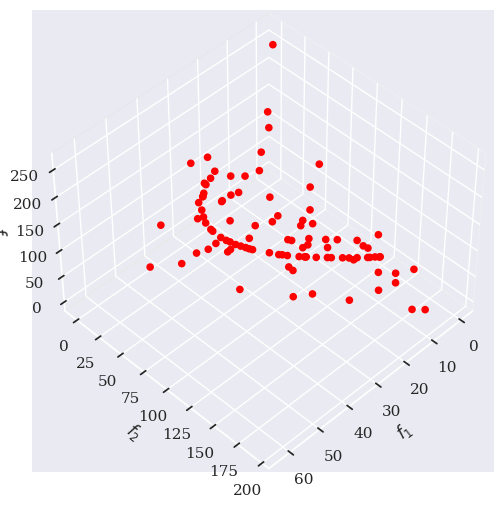

In [48]:
from pymoo.visualization.scatter import Scatter
#Fnsgaii = np.load('Solutions/nsgaii_baseline_dtlz1_F.npy')
Fnsgaii_samp = np.load('Solutions/nsgaii_samp-energy_dtlz1_F.npy')
plot = Scatter()
#plot.add(Fnsgaii[-1, -1, : ], color="black", alpha=0.7)
plot.add(Fnsgaii_samp[-1, -1, :], color="red")
plot.show()